In [1]:
import numpy as np
import pandas as pd
import cv2
import os

from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import metrics

2024-05-07 17:26:18.007797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 17:26:18.007904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 17:26:18.146757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base path
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data' #Chemin jusqu'aux dossiers Test Train Val
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [3]:
# Only run this cell if working files are not in kaggle working directory
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in tqdm(os.listdir(ima_dir)):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

100%|██████████| 2/2 [00:25<00:00, 12.61s/it]


In [4]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


In [5]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Standard Images

In [6]:
from tensorflow.keras.applications.xception import preprocess_input # Preprocess for XCeption model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    '''This function normalizes images by equalizing histograms (grayscale only)'''
    
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed


# Instanciation of image data generators using the preprocessing function defined before

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image) 
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [7]:
# Preprocessing of each folder

batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                           class_mode="sparse",
                                                           target_size=(299, 299),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                        classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                         class_mode="sparse",
                                                         target_size=(299, 299),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                         classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                          class_mode="sparse",
                                                          target_size=(299, 299),
                                                          batch_size=batch_size, shuffle=False)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
    
# Initializing Xception model with pre-trained weights, without the specific top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freezing 
for layer in base_model.layers: 
    layer.trainable = False

# Add final layers to the model
XCeption_base = Sequential()
XCeption_base.add(base_model)
XCeption_base.add(GlobalAveragePooling2D())
XCeption_base.add(Dense(512, activation='relu')) # Classification
XCeption_base.add(Dropout(rate=0.3)) # Help prevent overfitting
XCeption_base.add(Dense(256, activation='relu')) # Final classification
XCeption_base.add(Dropout(rate=0.4)) # Help prevent overfitting
XCeption_base.add(Dense(3, activation='softmax'))  # 3 classes at the end even though we are looking for 2

# Model compilation
XCeption_base.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
model_layers_count = len(XCeption_base.layers)
print("Number of layers in the model (base_model counts for 1 layer): ", model_layers_count)

Number of layers in the model (base_model counts for 1 layer):  7


In [10]:
base_model_layers_count = len(XCeption_base.layers[0].layers)
print("Number of layers in the base model: ", base_model_layers_count)

Number of layers in the base model:  132


In [11]:
print('First layer of the middle flow:', base_model.layers[36])
print('Middle flow start of the 2nd loop', base_model.layers[46])
print('Middle flow start of the 3rd loop', base_model.layers[56])
print('First layer of the exit flow', base_model.layers[116])
# https://arxiv.org/pdf/1610.02357
# Unfreezing from the start of the End flow, to be compared with middle flow unfreezing

First layer of the middle flow: <Activation name=block5_sepconv1_act, built=True>
Middle flow start of the 2nd loop <Activation name=block6_sepconv1_act, built=True>
Middle flow start of the 3rd loop <Activation name=block7_sepconv1_act, built=True>
First layer of the exit flow <Activation name=block13_sepconv1_act, built=True>


In [12]:
# Base model not to be touched
XCeption_exit = XCeption_base

In [13]:
# Exit model will be unfrozen only on the Exit Flow
for layer in XCeption_exit.layers[0].layers[116:]:
    layer.trainable = True

In [14]:
XCeption_exit.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

In [16]:
history_Xception_exit = XCeption_exit.fit(train_generator, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=val_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/678 ━━━━━━━━━━━━━━━━━━━━ 6:25:47 34s/step - accuracy: 0.2500 - loss: 1.2356

I0000 00:00:1715102965.588163      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


678/678 ━━━━━━━━━━━━━━━━━━━━ 182s 219ms/step - accuracy: 0.7580 - loss: 0.5612 - val_accuracy: 0.8920 - val_loss: 0.2813
Epoch 2/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 1:38 146ms/step - accuracy: 0.9062 - loss: 0.2093

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9062 - loss: 0.2093 - val_accuracy: 0.7778 - val_loss: 0.5905
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 125s 183ms/step - accuracy: 0.9091 - loss: 0.2429 - val_accuracy: 0.9284 - val_loss: 0.1838
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 1.0000 - loss: 0.0927 - val_accuracy: 1.0000 - val_loss: 0.0374
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 125s 184ms/step - accuracy: 0.9266 - loss: 0.1931 - val_accuracy: 0.9197 - val_loss: 0.2218
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.9688 - loss: 0.1262 - val_accuracy: 0.8889 - val_loss: 0.1549
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 125s 184ms/step - accuracy: 0.9428 - loss: 0.1443 - val_accuracy: 0.8474 - val_loss: 0.5355
Epoch 8/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.9375 - loss: 0.1666 - val_accuracy: 0.7778 - val_loss: 0.7497
Epoch 9/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 126s 184ms/step - accuracy: 0.9568 - loss: 0.1138 - val_accu

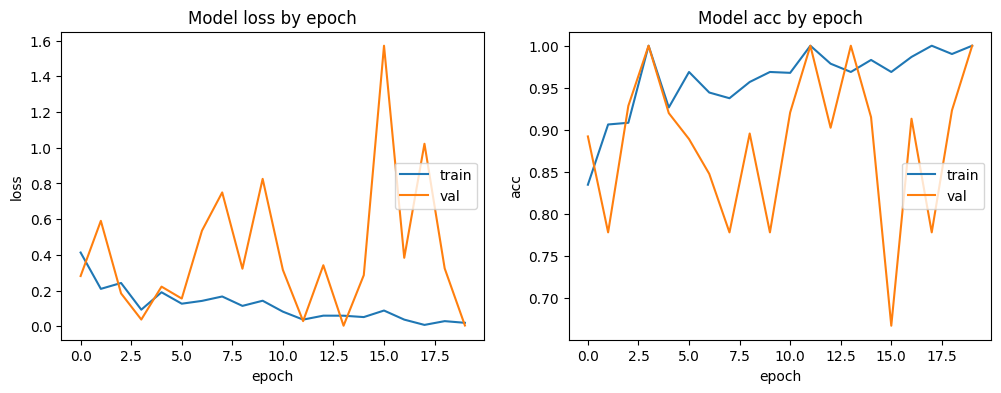

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Xception_exit.history['loss'])
plt.plot(history_Xception_exit.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_Xception_exit.history['accuracy'])
plt.plot(history_Xception_exit.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [18]:
evaluation_exit = XCeption_exit.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_exit[0])
print("Test Accuracy:", evaluation_exit[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.9598 - loss: 0.1625
Test Loss: 0.2553431987762451
Test Accuracy: 0.9384207129478455


In [19]:
# Base model not to be touched
XCeption_middle = XCeption_base

In [20]:
# Middle model will be unfrozen on the Middle & Exit Flow
for layer in XCeption_middle.layers[0].layers[36:]:
    layer.trainable = True

In [21]:
XCeption_middle.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

In [22]:
history_Xception_middle = XCeption_middle.fit(train_generator, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=val_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 278s 358ms/step - accuracy: 0.9149 - loss: 0.2268 - val_accuracy: 0.9336 - val_loss: 0.1756
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.2112 - val_accuracy: 0.8889 - val_loss: 0.1464
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 225s 330ms/step - accuracy: 0.9712 - loss: 0.0768 - val_accuracy: 0.9247 - val_loss: 0.2253
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - accuracy: 1.0000 - loss: 0.0444 - val_accuracy: 1.0000 - val_loss: 7.3243e-04
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 225s 330ms/step - accuracy: 0.9846 - loss: 0.0429 - val_accuracy: 0.9327 - val_loss: 0.2291
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.9375 - loss: 0.0676 - val_accuracy: 1.0000 - val_loss: 0.0453
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 224s 330ms/step - accuracy: 0.9861 - loss: 0.0360 - val_accuracy: 0.8894 - val_loss: 0.3743
Epoch 8/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.9688 - loss: 0.

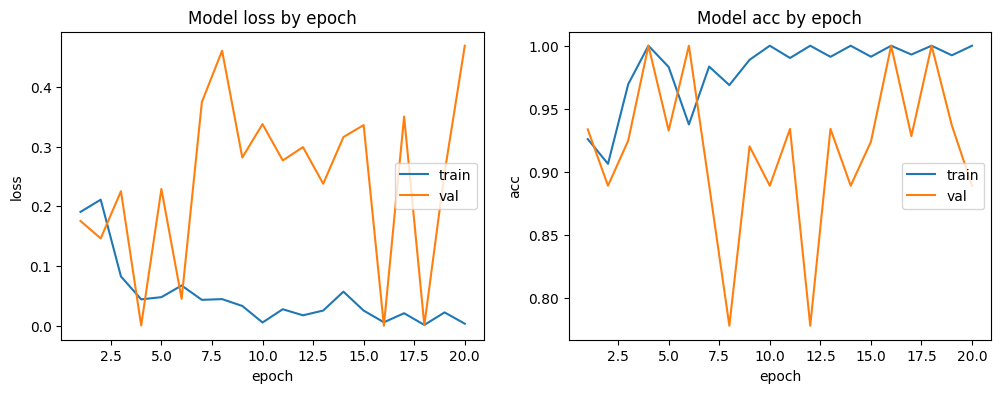

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(1,21,1), history_Xception_middle.history['loss'])
plt.plot(np.arange(1,21,1), history_Xception_middle.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(np.arange(1,21,1), history_Xception_middle.history['accuracy'])
plt.plot(np.arange(1,21,1), history_Xception_middle.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [24]:
evaluation_middle = XCeption_middle.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_middle[0])
print("Test Accuracy:", evaluation_middle[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - accuracy: 0.9679 - loss: 0.1234
Test Loss: 0.18453168869018555
Test Accuracy: 0.951974093914032


Masked images

In [25]:
def application_masks(image,mask):
    '''Cette fonction prend une image et applique un masque pour ne faire ressortir que les poumons'''
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
        
masks_applicated = "masks_applicated"
        
for sett in sets:
    for group in groups:
        ima_dir = os.path.join(base_path, sett, group, "images")
        mask_dir = os.path.join(base_path, sett, group, "lung masks")
    
        masks_applicated_path = os.path.join(destination_path, sett, group, masks_applicated)
    
        if not os.path.exists(masks_applicated_path):
            os.mkdir(masks_applicated_path) # Création du nouveau dossier pour stocker la combinaison si il n'existe pas déjà
        else :
            print("Le dossier existe déjà, l'application n'a pas été effectuée")
        
        for image in tqdm(os.listdir(ima_dir)):
            image_path = os.path.join(ima_dir, image) # Chemin de l'image
            image_read = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask_path = os.path.join(mask_dir, image) # Chemin du mask qui porte le même nom que l'image
            mask_read = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            result_image = application_masks(image_read, mask_read) # On applique le mask sur l'image
            result_image_path = os.path.join(destination_path, sett, group, masks_applicated, image) # On récupère le chemin de l'image dans le dossier
        
            cv2.imwrite(result_image_path, result_image) # On met l'image dans le nouveau dossier

100%|██████████| 7208/7208 [00:55<00:00, 129.97it/s]


In [26]:
# On déplace les masks car cela gène le Generator

mask_destination_path = '/kaggle/working/COVID-EX-Qu-dataset-mask'

for sett in sets:
    for group in groups:
        ima_dir = os.path.join(destination_path, sett, group)
        for dos in tqdm(os.listdir(ima_dir)):
            if dos=="masks_applicated":
                shutil.move(os.path.join(destination_path, sett, group, dos), os.path.join(mask_destination_path, sett, group, dos))

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


In [27]:
# Preprocessing of each "mask" folder

train_generator_mask = train_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Train'),
                                                           classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                           class_mode="sparse",
                                                           target_size=(299, 299),
                                                           batch_size=batch_size)

val_generator_mask = test_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Val'),
                                                        classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                         class_mode="sparse",
                                                         target_size=(299, 299),
                                                         batch_size=batch_size)

test_generator_mask = test_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Test'),
                                                         classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                          class_mode="sparse",
                                                          target_size=(299, 299),
                                                          batch_size=batch_size, shuffle=False)


Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [28]:
XCeption_mask = XCeption_base

In [29]:
# Mask model will be unfrozen on the Middle & Exit Flow (best of the 2 previous models)
for layer in XCeption_mask.layers[0].layers[36:]:
    layer.trainable = True

In [30]:
XCeption_mask.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nb_img_train_mask = train_generator_mask.samples
nb_img_val_mask = val_generator_mask.samples

In [31]:
history_Xception_mask = XCeption_mask.fit(train_generator_mask, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train_mask//batch_size,
                                validation_data=val_generator_mask,
                                validation_steps=nb_img_val_mask//batch_size
                                )

Epoch 1/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 273s 352ms/step - accuracy: 0.7950 - loss: 0.5228 - val_accuracy: 0.8608 - val_loss: 0.3579
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 0.5618 - val_accuracy: 0.8889 - val_loss: 0.3752
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 327ms/step - accuracy: 0.9041 - loss: 0.2559 - val_accuracy: 0.8519 - val_loss: 0.4016
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.8750 - loss: 0.3434 - val_accuracy: 0.6667 - val_loss: 0.5251
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 327ms/step - accuracy: 0.9434 - loss: 0.1504 - val_accuracy: 0.8737 - val_loss: 0.3590
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 1.0000 - loss: 0.0584 - val_accuracy: 0.8889 - val_loss: 0.2707
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 223s 327ms/step - accuracy: 0.9689 - loss: 0.0899 - val_accuracy: 0.8702 - val_loss: 0.4484
Epoch 8/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.9688 - loss: 0.0764

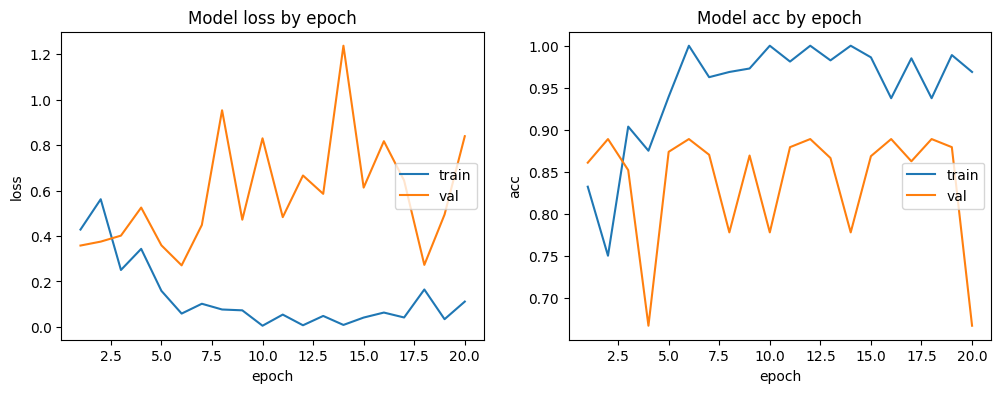

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(1,21,1), history_Xception_mask.history['loss'])
plt.plot(np.arange(1,21,1), history_Xception_mask.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(np.arange(1,21,1), history_Xception_mask.history['accuracy'])
plt.plot(np.arange(1,21,1), history_Xception_mask.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [33]:
evaluation_mask = XCeption_mask.evaluate(test_generator_mask)

# Print the evaluation metrics
print("Test Loss:", evaluation_mask[0])
print("Test Accuracy:", evaluation_mask[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.9076 - loss: 0.3537
Test Loss: 0.43671542406082153
Test Accuracy: 0.886711835861206


Trying to optimize the mask model

In [34]:
# Initializing Xception model with pre-trained weights, without the specific top layers
base_model_mask = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freezing 
for layer in base_model_mask.layers: 
    layer.trainable = False

# Add final layers to the model
XCeption_mask2 = Sequential()
XCeption_mask2.add(base_model)
XCeption_mask2.add(GlobalAveragePooling2D())
XCeption_mask2.add(Dense(256, activation='relu')) # Classification
XCeption_mask2.add(Dropout(rate=0.3)) # Help prevent overfitting
XCeption_mask2.add(Dense(128, activation='relu')) # Final classification
XCeption_mask2.add(Dropout(rate=0.4)) # Help prevent overfitting
XCeption_mask2.add(Dense(3, activation='softmax'))  # 3 classes at the end even though we are looking for 2

# Model compilation
XCeption_mask2.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [35]:
for layer in XCeption_mask2.layers[0].layers[36:]:
    layer.trainable = True

In [36]:
history_Xception_mask2 = XCeption_mask2.fit(train_generator_mask, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train_mask//batch_size,
                                validation_data=val_generator_mask,
                                validation_steps=nb_img_val_mask//batch_size
                                )

Epoch 1/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 276s 355ms/step - accuracy: 0.8137 - loss: 0.4992 - val_accuracy: 0.8358 - val_loss: 0.4729
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9062 - loss: 0.2852 - val_accuracy: 1.0000 - val_loss: 0.1151
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 327ms/step - accuracy: 0.8614 - loss: 0.3612 - val_accuracy: 0.8327 - val_loss: 0.4385
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.9375 - loss: 0.1860 - val_accuracy: 0.8889 - val_loss: 0.1918
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 326ms/step - accuracy: 0.8839 - loss: 0.3138 - val_accuracy: 0.8182 - val_loss: 0.6271
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.9375 - loss: 0.1868 - val_accuracy: 0.7778 - val_loss: 1.5088
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 326ms/step - accuracy: 0.9044 - loss: 0.2623 - val_accuracy: 0.8661 - val_loss: 0.3573
Epoch 8/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.9062 - loss: 0.2280

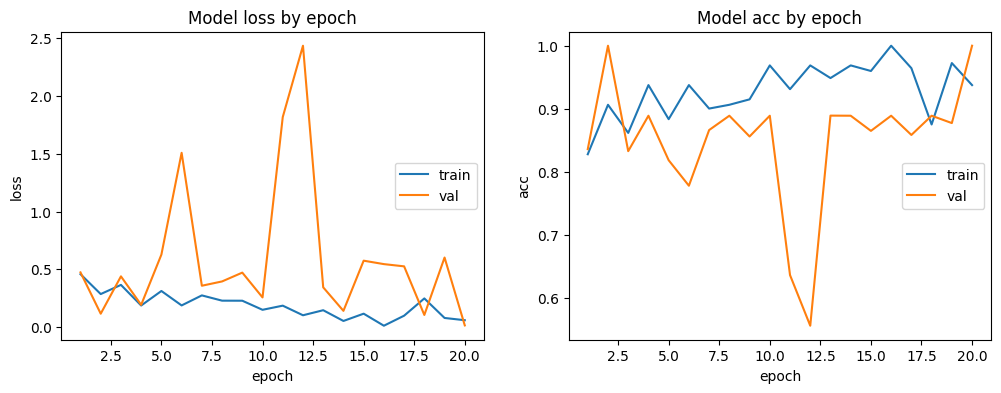

In [37]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(1,21,1), history_Xception_mask2.history['loss'])
plt.plot(np.arange(1,21,1), history_Xception_mask2.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(np.arange(1,21,1), history_Xception_mask2.history['accuracy'])
plt.plot(np.arange(1,21,1), history_Xception_mask2.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [38]:
evaluation_mask2 = XCeption_mask2.evaluate(test_generator_mask)

# Print the evaluation metrics
print("Test Loss:", evaluation_mask2[0])
print("Test Accuracy:", evaluation_mask2[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 131ms/step - accuracy: 0.8924 - loss: 0.5182
Test Loss: 0.5047088265419006
Test Accuracy: 0.8914260268211365


Dernier test en augmentant le nombre de neurones des couches de classification

In [39]:
# Initializing Xception model with pre-trained weights, without the specific top layers
base_model_final = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freezing 
for layer in base_model_final.layers: 
    layer.trainable = False

# Add final layers to the model
XCeption_final = Sequential()
XCeption_final.add(base_model)
XCeption_final.add(GlobalAveragePooling2D())
XCeption_final.add(Dense(1024, activation='relu')) # Classification
XCeption_final.add(Dropout(rate=0.3)) # Help prevent overfitting
XCeption_final.add(Dense(512, activation='relu')) # Final classification
XCeption_final.add(Dropout(rate=0.4)) # Help prevent overfitting
XCeption_final.add(Dense(3, activation='softmax'))  # 3 classes at the end even though we are looking for 2

# Model compilation
XCeption_final.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [40]:
for layer in XCeption_final.layers[0].layers[36:]:
    layer.trainable = True

In [41]:
history_Xception_final = XCeption_final.fit(train_generator, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=val_generator,
                                validation_steps=nb_img_val//batch_size
                                )

Epoch 1/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 278s 357ms/step - accuracy: 0.8919 - loss: 0.2880 - val_accuracy: 0.9142 - val_loss: 0.2281
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9688 - loss: 0.1198 - val_accuracy: 0.8889 - val_loss: 0.1901
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 225s 330ms/step - accuracy: 0.9630 - loss: 0.1012 - val_accuracy: 0.9101 - val_loss: 0.2838
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.9375 - loss: 0.1424 - val_accuracy: 1.0000 - val_loss: 0.0358
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 225s 330ms/step - accuracy: 0.9767 - loss: 0.0644 - val_accuracy: 0.8989 - val_loss: 0.3941
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.9375 - loss: 0.2008 - val_accuracy: 0.8889 - val_loss: 0.5386
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 225s 330ms/step - accuracy: 0.9823 - loss: 0.0576 - val_accuracy: 0.9277 - val_loss: 0.2425
Epoch 8/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 1.0000 - loss: 0.0053

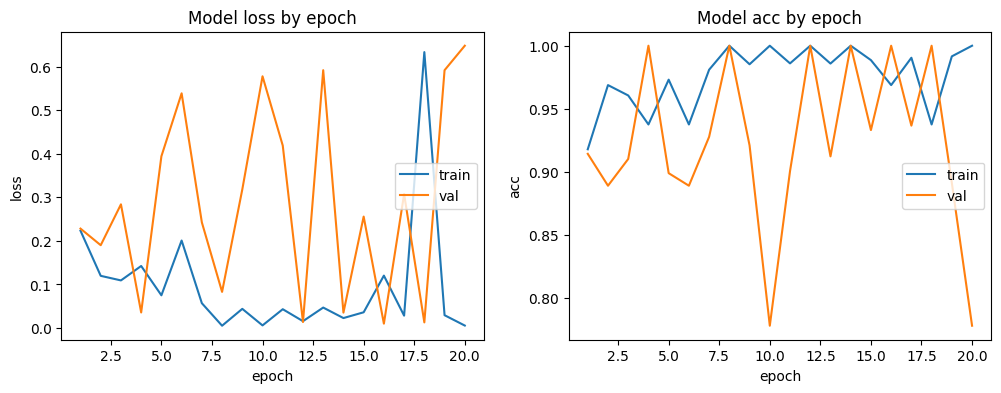

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(1,21,1), history_Xception_final.history['loss'])
plt.plot(np.arange(1,21,1), history_Xception_final.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(np.arange(1,21,1), history_Xception_final.history['accuracy'])
plt.plot(np.arange(1,21,1), history_Xception_final.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [43]:
evaluation_final = XCeption_final.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_final[0])
print("Test Accuracy:", evaluation_final[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.9641 - loss: 0.1800
Test Loss: 0.45978298783302307
Test Accuracy: 0.9176487922668457
